In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc('image', cmap='gray')

import numpy as np
np.random.seed(0)

from einops import rearrange

import cv2

In [2]:
barbara = cv2.imread('barbara.png')[:, :, 0] # nxn gray
cameraman = cv2.imread('cameraman.png')[:, :, 0]
lena = cv2.imread('lena.png')[:, :, 0]

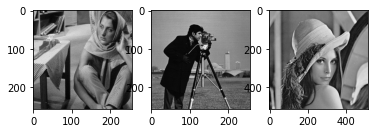

In [3]:
fig, axes = plt.subplots(1,3)
axes[0].imshow(barbara)
axes[1].imshow(cameraman)
axes[2].imshow(lena)

In [4]:
x = cameraman
n = x.shape[0]

In [5]:
e_var = 20
e = np.random.randn(n, n) * e_var

In [6]:
b = x + e
b[b < 0] = 0
b[b > 255] = 255

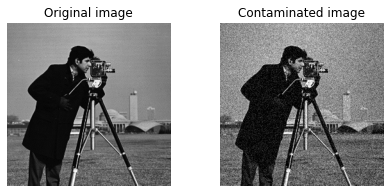

In [48]:
fig, (a1, a2) = plt.subplots(1, 2, figsize = (7, 3))

a1.imshow(x)
a1.set_title('Original image')

a2.imshow(b)
a2.set_title('Contaminated image')
a1.axis('off');a2.axis('off')
plt.savefig('img/task2.pdf')

In [8]:
nabla = np.zeros((n, n)) 
for i in range(n - 1):
    nabla[i, i] = -1
    nabla[i, i + 1] = 1

nabla

array([[-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0., -1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [9]:
np.diff(x, axis=0, append=x[[-1]])

array([[  0, 247, 248, ...,   6,   0,   0],
       [248,  16,   7, ...,   0,   0,   0],
       [ 16, 239,   1, ...,   0,   0,   0],
       ...,
       [248,   0,  14, ..., 249,   0, 251],
       [  8, 246,  10, ...,   3,   1,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

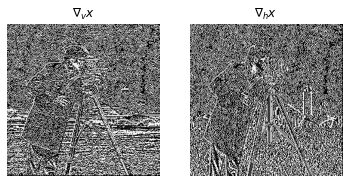

In [46]:
fig, (a1, a2) = plt.subplots(1, 2)
a1.imshow(np.diff(x, axis=0, append=x[[-1]]))
a2.imshow(np.diff(x, axis=1, append=x[:, [-1]]))
a1.axis('off');a2.axis('off');
a1.set_title('$\\nabla_v x$');a2.set_title('$\\nabla_h x$')
plt.savefig('img/hv.pdf')

In [11]:
def get_diff_0(x):
    """nabla @ x"""
    return np.diff(x, axis=0, append=x[[-1]])

def n(x):
    """nabla @ x"""
    return np.diff(x, axis=0, append=x[[-1]])

def get_diff_1(x):
    """(nabla @ x.T).T = x @ nabla.T"""
    return np.diff(x, axis=1, append=x[:, [-1]])

def nTn(x):
    """nabla.T @ nabla @ x """
    return nT(n(x))

def nT(x):
    """nabla.T @ x"""
    x = x.copy()
    x[-1] = 0
    return -np.diff(x, axis=0, prepend=0)

def _nTn(x):
    """x @ nabla.T @ nabla"""
    return (nTn(x.T)).T

In [12]:
def h(x):
    nx = n(x)
    nxT = n(x.T)
    return (nx ** 2).sum() + (nxT ** 2).sum()
    

def Phi(x, b, mu=1):
    """
    x.shape: (n, n, 3)
    """
    f = 1 / 2 * ((x - b) ** 2).sum()  
    return mu * h(x) + f

In [13]:
Phi(x, b)

18111427.687546313

In [14]:

def h_grad(x):
    return  2 * nTn(x) + 2 * _nTn(x)
    
    

def Phi_grad(x, b, mu=1):
    f_grad = x - b
    return mu * h_grad(x) + f_grad

Phi_grad(x, b).shape

(256, 256)

0.1111111111111111
0 360245600.66067195


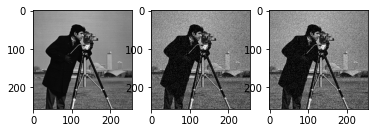

100 22990638.44647082


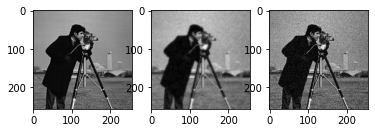

In [21]:
# train, Lipschitz constant L, step size

def get_Lip_const(mu=1, ita=1):
    L = 8 * mu + 1
    return L

MU = 1

L = get_Lip_const(mu=MU)

# y = x.copy() * 2
y = np.random.rand(*x.shape)
lr = 1 /(1 * L)
print(lr)

prev_Phi = np.inf
criterion = 1e-8
for i in range(10000):
    y -= lr * Phi_grad(y, b, mu=MU)
    curr_Phi = Phi(y, b, mu=MU)
    if np.abs(prev_Phi - curr_Phi) < criterion:
        break
    prev_Phi = curr_Phi
    
    # verbose print
    if i % 100 == 0:
        print(i, curr_Phi)
        
    if i % 100 == 0:
        fig, axes = plt.subplots(1, 3)
        axes[0].imshow(x.astype(np.uint8))
        axes[1].imshow(y.astype(np.uint8))
        axes[2].imshow(b.astype(np.uint8))
        plt.show()

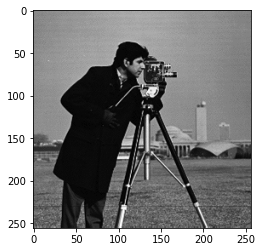

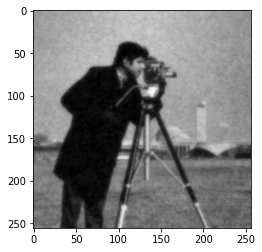

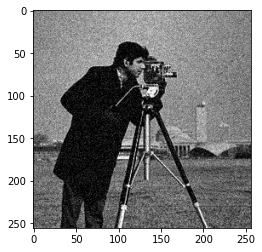

In [22]:
plt.imshow(x.astype(np.uint8))
plt.show()
plt.imshow(y.astype(np.uint8))
plt.show()
plt.imshow(b.astype(np.uint8))
plt.show()

lr = 0.2
0 293266098.92892903


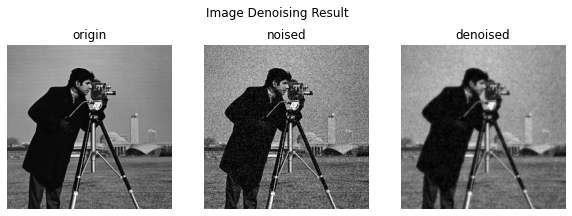

In [36]:
MU = 0.5

def Nesterov(mu=MU, criterion=1e-8):
    def get_Lip_const(mu=1, ita=1):
        L = 8 * mu + 1
        return L

    L = get_Lip_const(mu=mu)
    lr = 1 / L
    print(f'lr = {lr}')

    # init
    y = np.random.rand(*x.shape)
    
    # opt
    Phi_change_log = []
    prev_Phi = Phi(y, b, mu=mu)
    prev_Phi_grad = 0
    for i in range(10000):
        # Nesterov momentum
        a = (i - 1) / (i + 2)
        y -= a * lr * prev_Phi_grad
        
        y -= lr * Phi_grad(y, b, mu=mu)
        curr_Phi = Phi(y, b, mu=mu)
        
        Phi_change_log.append(np.abs(prev_Phi - curr_Phi).item())
        if np.abs(prev_Phi - curr_Phi) < criterion:
            break
        prev_Phi = curr_Phi
        prev_Phi_grad = Phi_grad(y, b, mu=mu)

        # verbose print
        if i % 1000 == 0:
            print(i, curr_Phi)
    
    return y, Phi_change_log
        
y, _ = Nesterov()

fig, (a1, a3, a2) = plt.subplots(1, 3, figsize=(10, 3.5))

a1.imshow(x.astype(np.uint8))
a1.set_title('origin')
a2.imshow(y.astype(np.uint8))
a2.set_title('denoised')
a3.imshow(b.astype(np.uint8))
a3.set_title('noised')
a1.axis('off');a2.axis('off');a3.axis('off')
plt.suptitle("Image Denoising Result")
plt.savefig('img/denoise.pdf')

In [37]:

y1, _ = Nesterov(mu=0.1)
y2, _ = Nesterov(mu=1)
y3, _ = Nesterov(mu=10)
y4, _ = Nesterov(mu=100)


lr = 0.5555555555555556
0 94183012.16758594
lr = 0.1111111111111111
0 360234058.8532039
lr = 0.012345679012345678
0 442733466.2250299
lr = 0.0012484394506866417
0 453029771.8333641
1000 60418802.39960141
2000 57844986.553403124
3000 57827881.12630394
4000 57827766.50108261
5000 57827765.73066354
6000 57827765.72547787


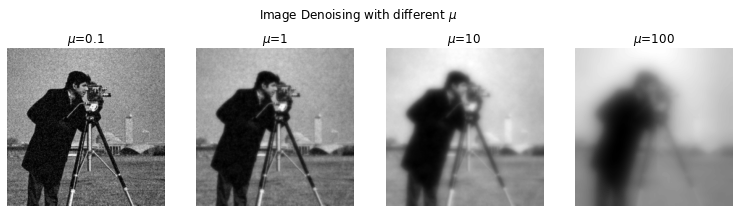

In [40]:

fig, (a1, a2, a3, a4) = plt.subplots(1, 4, figsize=(13, 3.5))

a1.imshow(y1.astype(np.uint8))
a1.set_title('$\mu$=0.1')
a2.imshow(y2.astype(np.uint8))
a2.set_title('$\mu$=1')
a3.imshow(y3.astype(np.uint8))
a3.set_title('$\mu$=10')
a4.imshow(y4.astype(np.uint8))
a4.set_title('$\mu$=100')
a1.axis('off');a2.axis('off');a3.axis('off');a4.axis('off')
plt.suptitle("Image Denoising with different $\mu$")
plt.savefig('img/denoise_mu.pdf')